In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| default_exp hierarchy

In [ ]:
#| export
#import numpy as np
import sys
import uuid
from pct.nodes import PCTNode
from pct.functions import WeightedSum
from pct.putils import UniqueNamer, FunctionsList, list_of_ones
from pct.functions import BaseFunction

In [ ]:
#| include: false
from pct.functions import Proportional

In [ ]:
#| export
class FunctionsData():
    "Data collected for a set of functions"
    def __init__(self):
        self.data = {}
            
    def add_data(self, func):
        name = func.get_name()
        if name in self.data.keys():
            self.data[name].append(func.get_value())
        else:
            dlist=[]
            self.data[name]=dlist
            self.data[name].append(func.get_value())
    
    def add_reward(self, func):
        name = 'reward'
        if name in self.data.keys():
            self.data[name].append(func.get_reward())
        else:
            dlist=[]
            self.data[name]=dlist
            self.data[name].append(func.get_reward())
            
    def add_list(self, key, list):
        self.data[key]= list

In [ ]:
#| export
class PCTHierarchy():
    "A hierarchical perceptual control system, of PCTNodes."
    def __init__(self, levels=0, cols=0, pre=None, post=None, name="pcthierarchy", clear_names=True, links="single", 
                 history=False, build=True, error_collector=None, namespace=None, **pargs):
        if namespace ==None:
            namespace = uuid.uuid1()
        self.namespace=namespace

        self.error_collector=error_collector
        self.links_built = False
        self.order=None
        self.history=history
        if clear_names:
            UniqueNamer.getInstance().clear(namespace=namespace)
        self.name=UniqueNamer.getInstance().get_name(namespace=namespace, name=name)
        if pre==None:
            self.preCollection=[]
        else:            
            self.preCollection=pre
        if post==None:
            self.postCollection=[]
        else:                 
            self.postCollection=post
        self.hierarchy = []
        self.prepost_data = None
        if history:
            self.prepost_data = FunctionsData()
            
        for r in range(levels):
            col_list=[]
            for c in range(cols):
                if links == "dense":
                    if r > 0:
                        perc = WeightedSum(weights=list_of_ones(cols), namespace=namespace)
                    if r < levels-1:
                        ref = WeightedSum(weights=list_of_ones(cols), namespace=namespace)
                    if r == 0:
                        if levels > 1:
                            node = PCTNode(reference=ref, name=f'level{r}col{c}', history=history, namespace=namespace)      
                        else:
                            node = PCTNode(name=f'level{r}col{c}', history=history, namespace=namespace)                              
                    if r > 0 and r == levels-1:                        
                        node = PCTNode(perception=perc, name=f'level{r}col{c}', history=history, namespace=namespace)
                    if r > 0 and r < levels-1:
                        node = PCTNode(perception=perc, reference=ref, history=history, name=f'level{r}col{c}', namespace=namespace)

                else:
                    node = PCTNode(name=f'level{r}col{c}', history=history, namespace=namespace)
                
                if build:
                    node.build_links()                    
                    self.handle_perception_links(node, r, c, links)
                    self.handle_reference_links(node, r, c, links)
                col_list.append(node)
                
            self.hierarchy.append(col_list)
    
    
    def __call__(self, verbose=False):

        for ctr in range(len(self.preCollection)):
            func = self.preCollection[ctr]
            func(verbose)
            if self.prepost_data != None:                
                self.prepost_data.add_data(func)
                if ctr == 0 and hasattr(func, 'reward'):
                    self.prepost_data.add_reward(func)

        if verbose:
            print()

        if self.order==None:
            for level in range(len(self.hierarchy)):
                for col in range(len(self.hierarchy[level])):
                    node  = self.hierarchy[level][col]
                    if verbose:
                        print(node.get_name(), end =" ")
                    node(verbose)
        elif self.order=="Down":
            for level in range(len(self.hierarchy)-1, -1, -1):
                for col in range(len(self.hierarchy[level])-1, -1, -1):
                    node  = self.hierarchy[level][col]
                    if verbose:
                        print(node.get_name(), end =" ")
                    node(verbose)                       
        else:
            for node_name in self.order:
                if verbose:
                    print(node_name, end =" ")
                FunctionsList.getInstance().get_function(self.namespace, node_name)(verbose)
        
        for func in self.postCollection:
            func(verbose)          
            if self.prepost_data != None:
                self.prepost_data.add_data(func)
        
        output = self.get_output_function().get_value()
        
        if self.error_collector != None:
            self.error_collector.add_data(self)
        
        if verbose:
            print()
        
        return output
    

    def set_name(self, name):
        self.name=name    
    
    def get_prepost_data (self):
        return self.prepost_data 
    
    def set_order(self, order):
        self.order=order
        
    def get_output_function(self):
        if len(self.postCollection) > 0:
            return self.postCollection[-1]
        
        return self.hierarchy[-1][-1].get_output_function()
        
    def add_preprocessor(self, func):
        self.preCollection.append(func)
        
    def add_postprocessor(self, func):
        self.postCollection.append(func)
 
    def get_preprocessor(self):
        return self.preCollection
        
    def get_postprocessor(self):
        return self.postCollection
 
    def run(self, steps=1, verbose=False):
        for i in range(steps):
            self.step = i
            try:
                if verbose:
                    print(f'[{i}]', end=' ')
                out = self(verbose)
            except Exception as ex:
                if ex.__str__().startswith('1000'):
                    self.error_collector.override_value()
                    if verbose:
                        print(f'Current score={self.error_collector.error()}')                    
                    return False
                elif ex.__str__().startswith('1001'):
                    return False

                raise ex

            if verbose:
                print(f'Current score={self.error_collector.error()}')
            
            if self.error_collector != None:
                if self.error_collector.is_limit_exceeded():
                    return out
                    
        return out
    
    def last_step(self):
        return self.step
        
    def get_node(self, level, col):
        return self.hierarchy[level][col]
    
    def get_error_collector(self):
        return self.error_collector

    def set_error_collector(self, error_collector):
        self.error_collector = error_collector

    def handle_perception_links(self, node, level, col, links_type):
        if level == 0 or links_type == None:
            return
        
        if links_type == "single":
            node.add_link("perception", self.hierarchy[level-1][col].get_function("perception"))
        
        if links_type == "dense":
            for column in range(len(self.hierarchy[level-1])):
                node.add_link("perception", self.hierarchy[level-1][column].get_function("perception"))

    def handle_reference_links(self, thisnode, level, col, links_type):
        if level == 0 or links_type == None:
            return
        
        if links_type == "single":
            thatnode = self.hierarchy[level-1][col]
            thatnode.add_link("reference", thisnode.get_function("output"))
        
        if links_type == "dense":
            for column in range(len(self.hierarchy[level-1])):
                thatnode = self.hierarchy[level-1][column]
                thatnode.add_link("reference", thisnode.get_function("output"))

    def get_grid(self):
        return [self.get_columns(level) for level in range(self.get_levels())]

    def get_node_positions(self, align='horizontal'):
        graph = self.graph()
        pos = nx.multipartite_layout(graph, subset_key="layer", align=align)
        return pos
 
            
    def draw(self, with_labels=True, with_edge_labels=False,  font_size=12, font_weight='bold', font_color='black', 
             color_mapping={'PL':'aqua','OL':'limegreen','CL':'goldenrod', 'RL':'red', 'I':'silver', 'A':'yellow'},
             node_size=500, arrowsize=25, align='horizontal', file=None, figsize=(8,8), move={}, 
             node_color=None, layout={'r':2,'c':1,'p':2, 'o':0}, funcdata=False):
        import networkx as nx
        import matplotlib.pyplot as plt
        self.graphv = self.graph(layout=layout, funcdata=funcdata)
        if node_color==None:
            node_color = self.get_colors(self.graphv, color_mapping)

        pos = nx.multipartite_layout(self.graphv, subset_key="layer", align=align)
        
        for key in move.keys():            
            pos[key][0]+=move[key][0]
            pos[key][1]+=move[key][1]
        
        plt.figure(figsize=figsize) 
        if with_edge_labels:
            edge_labels = self.get_edge_labels_wrapper(funcdata)
            nx.draw_networkx_edge_labels(self.graphv, pos=pos, edge_labels=edge_labels, font_size=font_size, 
                font_weight=font_weight, font_color='red', horizontalalignment='left')
            
        nx.draw(self.graphv, pos=pos, with_labels=with_labels, font_size=font_size, font_weight=font_weight, 
                font_color=font_color, node_color=node_color,  node_size=node_size, arrowsize=arrowsize)
        
        if file != None:
            plt.title(self.name)
            plt.tight_layout()
            plt.savefig(file)

    def get_colors(self, graph, color_mapping):
        colors=[]
        for node in graph:
            color = 'darkorchid'
            for key in color_mapping.keys():                
                if node.startswith(key):
                    color = color_mapping[key]
                    break
            colors.append(color)
        return colors
            
    def reset(self):
        for func in self.preCollection:
            func.set_value(0)               

        for func in self.postCollection:
            func.set_value(0)

        for level in self.hierarchy:
            for node in level:
                node.reset()

        
    def reset_checklinks(self, val=True):
        for func in self.postCollection:
            func.reset_checklinks(val)
                    
        for func in self.preCollection:
            func.reset_checklinks(val)
            
        for level in self.hierarchy:
            for node in level:
                node.reset_checklinks(val)
                
    def get_edge_labels_wrapper(self, funcdata=False):
        if funcdata:
            return self.get_edge_labels_funcdata()
        else:
            return self.get_edge_labels()

        
    def get_edge_labels_funcdata(self):
        labels={}
       
        for func in self.postCollection:
            func.get_weights_labels_funcdata(labels)
                    
        for func in self.preCollection:
            func.get_weights_labels_funcdata(labels)
            
        for level in self.hierarchy:
            for node in level:
                node.get_edge_labels_funcdata(labels)
                
        return labels
        
        
    def get_edge_labels(self):
        labels={}
       
        for func in self.postCollection:
            func.get_weights_labels(labels)
                    
        for func in self.preCollection:
            func.get_weights_labels(labels)
            
        for level in self.hierarchy:
            for node in level:
                node.get_edge_labels(labels)
                
        return labels

    def change_namespace(self):        
        namespace = uuid.uuid1()
        self.namespace=namespace       
        self.name=UniqueNamer.getInstance().get_name(namespace=namespace, name=self.name)
        
        for func in self.postCollection:
            func.change_namespace(namespace)
                    
        for func in self.preCollection:
            func.change_namespace(namespace)
            
        for level in self.hierarchy:
            for node in level:
                node.change_namespace(namespace)
                
    
    def get_graph(self):
        return self.graphv
    
    def clear_graph(self):
        self.graphv.clear()

    def graph(self, layout={'r':2,'c':1,'p':2, 'o':0}, funcdata=False):
        import networkx as nx
        graph = nx.DiGraph()
        
        if funcdata:
            self.set_graph_data_funcdata(graph, layout=layout)
        else:
            self.set_graph_data(graph, layout=layout)
                
        return graph
    
    
    def set_graph_data(self, graph, layout={'r':2,'c':1,'p':2, 'o':0}):
        layer=0
        if len(self.preCollection)>0 or len(self.postCollection)>0:
            layer=1
            
        for func in self.postCollection:
            func.set_graph_data(graph, layer=0)  

        for func in self.preCollection:
            func.set_graph_data(graph, layer=0)   
                    
        for level in range(len(self.hierarchy)):
            for col in range(len(self.hierarchy[level])-1, -1, -1):
            #for col in range(len(self.hierarchy[level])):
                  self.hierarchy[level][col].set_graph_data(graph, layer=layer, layout=layout)
            layer+=3

            
            
    def set_graph_data_funcdata(self, graph, layout={'r':2,'c':1,'p':2, 'o':0}):
        layer=0
        if len(self.preCollection)>0 or len(self.postCollection)>0:
            layer=1
            
        for func in self.postCollection:
            func.set_graph_data_funcdata(graph, layer=0)  

        for func in self.preCollection:
            func.set_graph_data_funcdata(graph, layer=0)   
                    
        for level in range(len(self.hierarchy)):
            for col in range(len(self.hierarchy[level])-1, -1, -1):
            #for col in range(len(self.hierarchy[level])):
                  self.hierarchy[level][col].set_graph_data_funcdata(graph, layer=layer, layout=layout)
            layer+=3
            
            
            
#     def draw_nodes(self, with_labels=True, with_edge_labels=False,  font_size=12, font_weight='bold', node_color=None,  
#          color_mapping={'L':'red', 'I':'silver', 'A':'yellow'},
#          node_size=500, arrowsize=25, align='horizontal', file=None, figsize=(8,8), move={}):
#         graph = self.graph_nodes()
#         if node_color==None:
#             node_color = self.get_colors(graph, color_mapping)

#         pos = nx.multipartite_layout(graph, subset_key="layer", align=align)

#         for key in move.keys():            
#             pos[key][0]+=move[key][0]
#             pos[key][1]+=move[key][1]

#         plt.figure(figsize=figsize) 
#         if with_edge_labels:
#             edge_labels = self.get_edge_labels_nodes()
#             nx.draw_networkx_edge_labels(graph, pos=pos, edge_labels=edge_labels, font_size=font_size, font_weight=font_weight, 
#                 font_color='red')
#         nx.draw(graph, pos=pos, with_labels=with_labels, font_size=font_size, font_weight=font_weight, 
#                 node_color=node_color,  node_size=node_size, arrowsize=arrowsize)

#         if file != None:
#             plt.title(self.name)
#             plt.savefig(file)

    def get_edge_labels_nodes(self, node_list):
        labels={}

        for func in self.postCollection:
            func.get_weights_labels_nodes(labels, node_list)

        for func in self.preCollection:
            func.get_weights_labels_nodes(labels, node_list)

        for level in self.hierarchy:
            for node in level:
                node.get_edge_labels(labels)

        return labels

    def change_link_name(self, old_name, new_name):
        for func in self.postCollection:
            func.links = [new_name if i==old_name else i for i in func.links ]

        for func in self.preCollection:
            func.links = [new_name if i==old_name else i for i in func.links ]

        for level in range(len(self.hierarchy)):
            for col in range(len(self.hierarchy[level])):
                  self.hierarchy[level][col].change_link_name(old_name, new_name)
        
    def set_suffixes(self):
        functionsList = FunctionsList.getInstance()
        # change names
        for key in functionsList.functions[self.namespace].keys():
            func = functionsList.get_function(self.namespace, key)
            if isinstance (func, BaseFunction):
                name = func.get_name()
                #print(name)
                suffix = func.get_suffix()
                if len(suffix)>0:
                    func.name = name+suffix
                    self.change_link_name(key, func.name)

        keys = list(functionsList.functions[self.namespace].keys())
        for key in keys:
            func = functionsList.get_function(self.namespace,key)
            if isinstance (func, BaseFunction):
                name = func.get_name()
                #print(key, name)
                if key != name:
                    popped = functionsList.functions[self.namespace].pop(key)
                    functionsList.functions[self.namespace][name] = popped


    def get_levels(self):
        return len(self.hierarchy)
    
    def get_columns(self, level):
        return len(self.hierarchy[level])

#     def graph_nodes(self):
#         graph = nx.DiGraph()

#         self.set_graph_data_nodes(graph)

#         return graph

#     def set_graph_data_nodes(self, graph):
#         layer=0
#         if len(self.preCollection)>0 or len(self.postCollection)>0:
#             layer=1

#         node_list={}
#         for level in range(len(self.hierarchy)):
#             for col in range(len(self.hierarchy[level])-1, -1, -1):
#                 node = self.hierarchy[level][col]
#                 node.get_node_list(node_list)

#         for func in self.preCollection:
#             node_list[func.get_name()] = func.get_name()

#         for func in self.postCollection:
#             node_list[func.get_name()] = func.get_name()

#         for func in self.postCollection:
#             func.set_graph_data_node(graph, layer=0, node_list=node_list)

#         for func in self.preCollection:
#             func.set_graph_data_node(graph, layer=0, node_list=node_list)

#         edges = []
#         for level in range(len(self.hierarchy)):
#             for col in range(len(self.hierarchy[level])-1, -1, -1):
#                 node = self.hierarchy[level][col]
#                 graph.add_node(node.get_name(), layer=level+layer)

#                 for func in node.referenceCollection:
#                     for link in func.links:
#                         if isinstance(link, str):
#                             name=link
#                         else:
#                             name = link.get_name()                            
#                         edges.append((node_list[name],node.get_name()))

#                 for func in node.perceptionCollection:
#                     for link in func.links:
#                         if isinstance(link, str):
#                             name=link
#                         else:
#                             name = link.get_name()                            
#                         edges.append((node_list[name],node.get_name()))
                        
#         graph.add_edges_from(edges)

    
    def build_links(self):
        for level in range(len(self.hierarchy)):
            for col in range(len(self.hierarchy[level])):
                  self.hierarchy[level][col].build_links()
        

    def clear_values(self):
        for func in self.postCollection:
            func.value = 0

        for func in self.preCollection:
            func.value = 0
                    
        for level in range(len(self.hierarchy)):
            for col in range(len(self.hierarchy[level])):
                  self.hierarchy[level][col].clear_values()

    def error(self):
        error = 0
        for level in range(len(self.hierarchy)):
             for col in range(len(self.hierarchy[level])):
                    error += self.hierarchy[level][col].get_function("comparator").get_value()
        return error

    def insert_level(self, level):
        cols_list=[]
        self.hierarchy.insert(level, cols_list)
        
    def remove_level(self, lvl):
        level = self.hierarchy.pop(lvl)
        for node in level:
            node.delete_contents()
            del node
        del level


    def remove_nodes(self, level, num_nodes):        
        for _ in range(num_nodes):
            del self.hierarchy[level][-1]

    def summary(self, build=False, extra=False):
        print("**************************")
        print(self.name, type(self).__name__, self.get_grid(), self.namespace)                
        print("--------------------------")
        print("PRE:", end=" ")
        if len(self.preCollection) == 0:
            print("None")
        for func in self.preCollection:
            func.summary(extra=extra)   
        
            
        if self.order==None:
            for level in range(len(self.hierarchy)):
                print(f'Level {level} Cols {self.get_columns(level)}')
                for col in range(len(self.hierarchy[level])):
                      self.hierarchy[level][col].summary(build=build, extra=extra)
        elif self.order=="Down":
            for level in range(len(self.hierarchy)-1, -1, -1):
                print(f'Level {level} Cols {self.get_columns(level)}')
                for col in range(len(self.hierarchy[level])-1, -1, -1):
                      self.hierarchy[level][col].summary(build=build, extra=extra)
                                             
        print("POST:", end=" ")
        if len(self.postCollection) == 0:
            print("None")
        for func in self.postCollection:
            func.summary(extra=extra)   


        print("**************************")
            
    def save(self, file=None, indent=4):
        import json
        jsondict = json.dumps(self.get_config(), indent=indent)
        f = open(file, "w")
        f.write(jsondict)
        f.close()
        
    @classmethod
    def load(cls, file, clear=True, namespace=None):
        if clear:
            FunctionsList.getInstance().clear()

        with open(file) as f:
            config = json.load(f)
        return cls.from_config(config, namespace=namespace)
                   
    def get_config(self, zero=1):
        config = {"type": type(self).__name__,
                    "name": self.name}        
        
        pre = {}
        for i in range(len(self.preCollection)):
            pre[f'pre{i}']=self.preCollection[i].get_config(zero=zero)
        config['pre']=pre

        
        levels = {}
        for lvl in range(len(self.hierarchy)):
            level ={'level':lvl}
            columns={}
            for col in range(len(self.hierarchy[lvl])):
                column={'col':col}
                nodeconfig = self.hierarchy[lvl][col].get_config(zero=zero)
                #print(nodeconfig)
                column['node']=nodeconfig
                #print(column)
                columns[f'col{col}']=column
            level['nodes']=columns
            levels[f'level{lvl}']=level
        config['levels']=levels
        
        post = {}
        for i in range(len(self.postCollection)):
            post[f'post{i}']=self.postCollection[i].get_config(zero=zero)
        config['post']=post
        return config       

    
    @classmethod
    def from_config(cls, config, namespace=None):
        hpct = PCTHierarchy(name=config['name'], namespace=namespace)
        namespace = hpct.namespace
        preCollection = []        
        coll_dict = config['pre']
        PCTNode.collection_from_config(preCollection, coll_dict, namespace=namespace)
        
        postCollection = []        
        coll_dict = config['post']
        PCTNode.collection_from_config(postCollection, coll_dict, namespace=namespace)
     
        hpct.preCollection=preCollection
        hpct.postCollection=postCollection
                
        hpct.hierarchy=[]
        for level_key in config['levels'].keys():
            cols = []
            for nodes_key in config['levels'][level_key]['nodes'].keys():
                node = PCTNode.from_config(config['levels'][level_key]['nodes'][nodes_key]['node'], namespace=namespace)
                cols.append(node)
            hpct.hierarchy.append(cols)
        
    
        return hpct
    

    def add_node(self, node, level=-1, col=-1):
        
        if len(self.hierarchy)==0:
            self.hierarchy.append([])

        if level<0 and col<0:
            self.hierarchy[0].append(node)
        else:
            levels = len(self.hierarchy)
            if level == levels:
                self.hierarchy.append([])      
            self.hierarchy[level].insert(col, node)
        
    def insert_function(self, level=None, col=None, collection=None, function=None, position=-1):
        self.hierarchy[level][col].insert_function(collection, function, position)

    def replace_function(self, level=None, col=None, collection=None, function=None, position=-1):
        self.hierarchy[level][col].replace_function(collection, function, position)

    def get_function(self, level=None, col=None, collection=None, position=-1):
        return self.hierarchy[level][col].get_function(collection, position)

    def set_links(self, func_name, *link_names):
        func = FunctionsList.getInstance().get_function(self.namespace, func_name)
        func.clear_links()
        for link_name in link_names:
            func.add_link(FunctionsList.getInstance().get_function(self.namespace, link_name))
            
    def add_links(self, func_name, *link_names):
        for link_name in link_names:
            FunctionsList.getInstance().get_function(self.namespace, func_name).add_link(FunctionsList.getInstance().get_function(self.namespace, link_name))
            
            
    def get_history_data(self):
        history_data = self.get_prepost_data()
        #for key in history_data.data.keys():
        #    print(key)

        for level in range(len(self.hierarchy)):
            for col in range(len(self.hierarchy[level])):
                node = self.get_node(level,col)
                for key in node.history.data['refcoll'].keys():
                    #print(key)
                    history_data.add_list(key,node.history.data['refcoll'][key])
                for key in node.history.data['percoll'].keys():
                    #print(key)
                    history_data.add_list(key,node.history.data['percoll'][key])
                for key in node.history.data['comcoll'].keys():
                    #print(key)
                    history_data.add_list(key,node.history.data['comcoll'][key])
                for key in node.history.data['outcoll'].keys():
                    #print(key)
                    history_data.add_list(key,node.history.data['outcoll'][key])

        return history_data.data            
    
    def hierarchy_plots(self, title='plot', plot_items={}, figsize=(15,4), file=None):
        from matplotlib import style
        import matplotlib.pyplot as plt
        history = self.get_history_data()

        num_items = len(history[list(history.keys())[0]])
        #x = np.linspace(0, num_items-1, num_items)
        x =  [i for i in range(num_items)]
        style.use('fivethirtyeight')

        fig = plt.figure(figsize=figsize)
        ax1 = fig.add_subplot(1,1,1)

        for key in plot_items.keys():    
            ax1.plot(x, history[key], label=plot_items[key])

        if file != None:
            plt.title(title)
            plt.legend()
            plt.savefig(file)
            
        # plt.show()

        return fig
    
    def get_parameters_list(self):

        pre = []
        post = []

        for func in self.preCollection:
            pre.append(func.get_parameters_list())
        
        for func in self.postCollection:
            post.append(func.get_parameters_list())
                    
        lowest = [pre, post]

        hpct=[lowest]
        
        for level in self.hierarchy:
            level_list=[]
            for node in level:
                level_list.append(node.get_parameters_list())
            hpct.append(level_list)
                
        return hpct
    
    
    @classmethod
    def run_from_config(cls, config, min, render=False,  error_collector_type=None, error_response_type=None, 
        error_properties=None, error_limit=100, steps=500, hpct_verbose=False, early_termination=False, 
        seed=None, draw_file=None, move=None, with_edge_labels=True, font_size=6, node_size=100, plots=None,
        history=False, suffixes=False, plots_figsize=(15,4), plots_dir=None, flip_error_response=False):
        "Run an individual from a provided configuration."
        #if hpct_verbose:
        #print(config)
        ind = cls.from_config(config, seed=seed, history=history, suffixes=suffixes)
        env = ind.get_preprocessor()[0]
        env.set_render(render)
        env.early_termination = early_termination
        env.reset(full=False, seed=seed)
        error_collector = BaseErrorCollector.collector(error_response_type, error_collector_type, error_limit, min, properties=error_properties, flip_error_response=flip_error_response)

        ind.set_error_collector(error_collector)
        if hpct_verbose:
            ind.summary()
            print(ind.formatted_config())
        ind.run(steps, hpct_verbose)
        env.close()
        
        # draw network file
        move = {} if move == None else move
        if draw_file is not None:
            ind.draw(file=draw_file, move=move, with_edge_labels=with_edge_labels, font_size=font_size, node_size=node_size)
            print(draw_file)
        
        if history:
            for plot in plots:
                fig = ind.hierarchy_plots(title=plot['title'], plot_items=plot['plot_items'], figsize=plots_figsize, file=plots_dir+ sep +plot['title']+'.png')

        score=ind.get_error_collector().error()
        
        return ind, score    

## Creating a Hierarchy

Create a hierarchy by defining the number of rows (levels) and columns.

In [ ]:
from pct.functions import Constant

In [ ]:
pre=Constant(5, name='precon')
namespace=pre.namespace
post=Constant(10, name='postcon', namespace=namespace)
hpct = PCTHierarchy(3,3, pre=[pre], post=[post], history=True, clear_names=False, links="dense", namespace=namespace)
hpct.hierarchy

[[<pct.nodes.PCTNode>,
  <pct.nodes.PCTNode>,
  <pct.nodes.PCTNode>],
 [<pct.nodes.PCTNode>,
  <pct.nodes.PCTNode>,
  <pct.nodes.PCTNode>],
 [<pct.nodes.PCTNode>,
  <pct.nodes.PCTNode>,
  <pct.nodes.PCTNode>]]

In [ ]:
print(hpct.get_parameters_list())

[[[[5]], [[10]]], [[[[1, 1, 1]], [[0]], [[1]]], [[[1, 1, 1]], [[0]], [[1]]], [[[1, 1, 1]], [[0]], [[1]]]], [[[[1, 1, 1]], [[1, 1, 1]], [[1]]], [[[1, 1, 1]], [[1, 1, 1]], [[1]]], [[[1, 1, 1]], [[1, 1, 1]], [[1]]]], [[[[0]], [[1, 1, 1]], [[1]]], [[[0]], [[1, 1, 1]], [[1]]], [[[0]], [[1, 1, 1]], [[1]]]]]


In [ ]:
print(hpct.get_grid())

[3, 3, 3]


In [ ]:
hpct.change_namespace()

In [ ]:
hpct.summary()

**************************
pcthierarchy PCTHierarchy [3, 3, 3] aeb6d1eb-dd58-11ed-ae3e-5c879cf9f59b
--------------------------
PRE: precon Constant | 5 
Level 0 Cols 3
level0col0 PCTNode
----------------------------
REF: weighted_sum WeightedSum | weights [1, 1, 1] | 0 | links  proportional3 proportional4 proportional5 
PER: variable Variable | 0 
COM: subtract Subtract | 0 | links  weighted_sum variable 
OUT: proportional Proportional | gain 1 | 0 | links  subtract 
----------------------------
level0col1 PCTNode
----------------------------
REF: weighted_sum1 WeightedSum | weights [1, 1, 1] | 0 | links  proportional3 proportional4 proportional5 
PER: variable1 Variable | 0 
COM: subtract1 Subtract | 0 | links  weighted_sum1 variable1 
OUT: proportional1 Proportional | gain 1 | 0 | links  subtract1 
----------------------------
level0col2 PCTNode
----------------------------
REF: weighted_sum2 WeightedSum | weights [1, 1, 1] | 0 | links  proportional3 proportional4 proportional5 
PER:

In [ ]:
#FunctionsList.getInstance().report()    

Create a hierarchy from a configuration.

In [ ]:
config = hpct.get_config()
print(config)

{'type': 'PCTHierarchy', 'name': 'pcthierarchy', 'pre': {'pre0': {'type': 'Constant', 'name': 'precon', 'value': 5, 'links': {}}}, 'levels': {'level0': {'level': 0, 'nodes': {'col0': {'col': 0, 'node': {'type': 'PCTNode', 'name': 'level0col0', 'refcoll': {'0': {'type': 'WeightedSum', 'name': 'weighted_sum', 'value': 0, 'links': {0: 'proportional3', 1: 'proportional4', 2: 'proportional5'}, 'weights': [1, 1, 1]}}, 'percoll': {'0': {'type': 'Variable', 'name': 'variable', 'value': 0, 'links': {}}}, 'comcoll': {'0': {'type': 'Subtract', 'name': 'subtract', 'value': 0, 'links': {0: 'weighted_sum', 1: 'variable'}}}, 'outcoll': {'0': {'type': 'Proportional', 'name': 'proportional', 'value': 0, 'links': {0: 'subtract'}, 'gain': 1}}}}, 'col1': {'col': 1, 'node': {'type': 'PCTNode', 'name': 'level0col1', 'refcoll': {'0': {'type': 'WeightedSum', 'name': 'weighted_sum1', 'value': 0, 'links': {0: 'proportional3', 1: 'proportional4', 2: 'proportional5'}, 'weights': [1, 1, 1]}}, 'percoll': {'0': {'ty

In [ ]:
h = PCTHierarchy.from_config(config, namespace=namespace)

In [ ]:
assert h.get_config() == hpct.get_config()

## Viewing a Hierarchy

The hierarchy details can be viewed as a summary. 

In [ ]:
hpct.get_node(2,0).get_function('reference').set_value(1)
hpct.get_node(2,1).get_function('reference').set_value(1)
hpct.get_node(2,2).get_function('reference').set_value(1)
for level in range(3):
    for col in range(3):
        hpct.get_node(level,col).get_function('output').set_property('gain', 10)
hpct.summary()

**************************
pcthierarchy PCTHierarchy [3, 3, 3] aeb6d1eb-dd58-11ed-ae3e-5c879cf9f59b
--------------------------
PRE: precon Constant | 5 
Level 0 Cols 3
level0col0 PCTNode
----------------------------
REF: weighted_sum WeightedSum | weights [1, 1, 1] | 0 | links  proportional3 proportional4 proportional5 
PER: variable Variable | 0 
COM: subtract Subtract | 0 | links  weighted_sum variable 
OUT: proportional Proportional | gain 10 | 0 | links  subtract 
----------------------------
level0col1 PCTNode
----------------------------
REF: weighted_sum1 WeightedSum | weights [1, 1, 1] | 0 | links  proportional3 proportional4 proportional5 
PER: variable1 Variable | 0 
COM: subtract1 Subtract | 0 | links  weighted_sum1 variable1 
OUT: proportional1 Proportional | gain 10 | 0 | links  subtract1 
----------------------------
level0col2 PCTNode
----------------------------
REF: weighted_sum2 WeightedSum | weights [1, 1, 1] | 0 | links  proportional3 proportional4 proportional5 
PE

The hierarchy details can be viewed as a configuration. That configuration can be used to create a hierarchy, as shown above.

In [ ]:
hpct.get_config()

{'type': 'PCTHierarchy',
 'name': 'pcthierarchy',
 'pre': {'pre0': {'type': 'Constant',
   'name': 'precon',
   'value': 5,
   'links': {}}},
 'levels': {'level0': {'level': 0,
   'nodes': {'col0': {'col': 0,
     'node': {'type': 'PCTNode',
      'name': 'level0col0',
      'refcoll': {'0': {'type': 'WeightedSum',
        'name': 'weighted_sum',
        'value': 0,
        'links': {0: 'proportional3', 1: 'proportional4', 2: 'proportional5'},
        'weights': [1, 1, 1]}},
      'percoll': {'0': {'type': 'Variable',
        'name': 'variable',
        'value': 0,
        'links': {}}},
      'comcoll': {'0': {'type': 'Subtract',
        'name': 'subtract',
        'value': 0,
        'links': {0: 'weighted_sum', 1: 'variable'}}},
      'outcoll': {'0': {'type': 'Proportional',
        'name': 'proportional',
        'value': 0,
        'links': {0: 'subtract'},
        'gain': 10}}}},
    'col1': {'col': 1,
     'node': {'type': 'PCTNode',
      'name': 'level0col1',
      'refcoll':

Get the output function, which will be the output function of the last node, or the last item of the post-processor functions, if present.

In [ ]:
link = hpct.get_output_function()
print(link.get_config())

{'type': 'Constant', 'name': 'postcon', 'value': 10, 'links': {}}


The hierarhcy can also be viewed graphically as a network of connected nodes.

In [ ]:
import os

C:\Users\ryoung\AppData\Local\Temp\ipykernel_9196\547485848.py:235: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


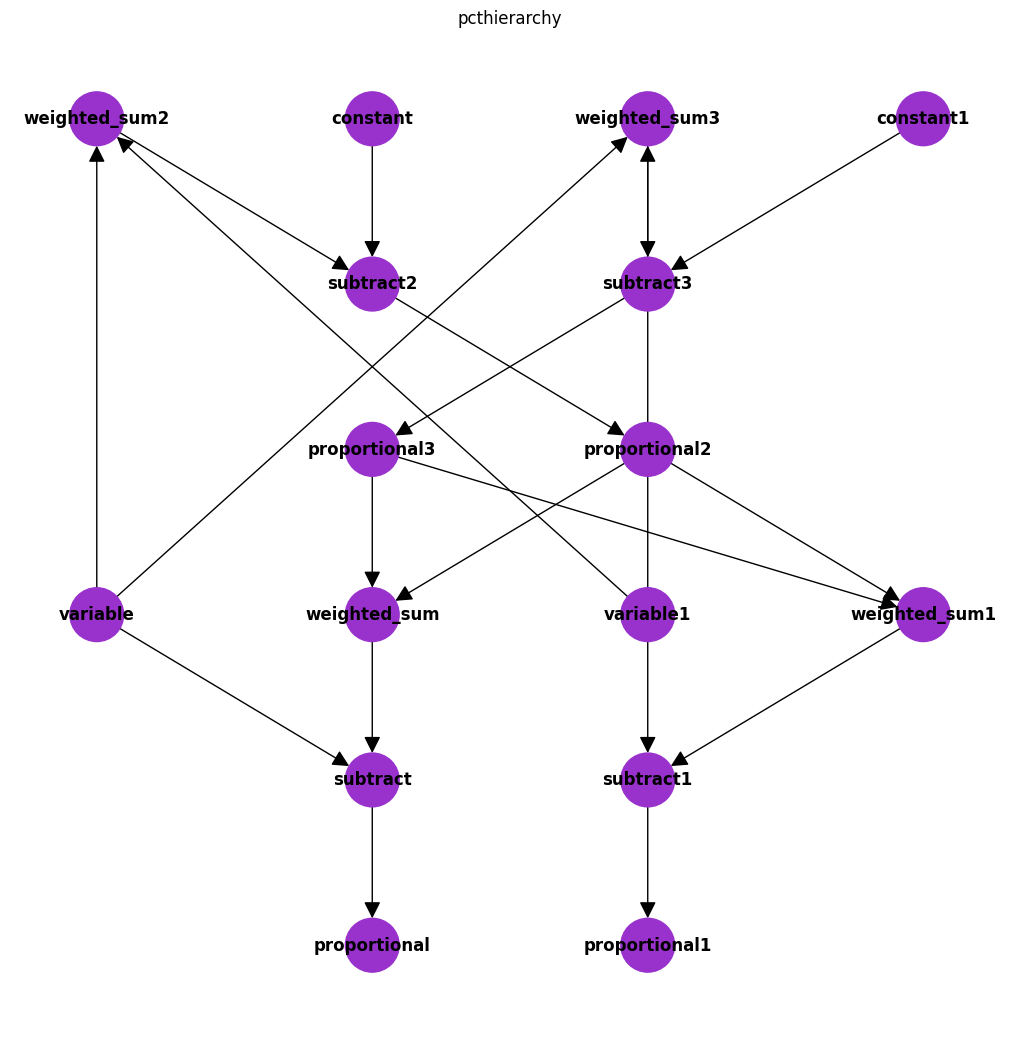

In [ ]:
ahpct = PCTHierarchy(2,2, links="dense")

test = 3
if test==1:
    g = ahpct.graph()
    pos=graphviz_layout(g, prog='dot')
    nx.draw(g, pos=pos, with_labels=True, font_size=12, font_weight='bold', node_color='red',  node_size=500)

if test ==2:
    g = ahpct.graph()
    pos = nx.multipartite_layout(g, subset_key="layer", align='horizontal')
    pos['constant1'][0]+=0.2
    c = pos['constant1'][0]
    print(c)
    nx.draw(g, pos=pos, with_labels=True, font_weight='bold', node_color='red',  node_size=750, arrowsize=25)

if test ==3:
    if os.name=='nt':        
        ahpct.draw(file="ahpct.png",  node_size=1500, figsize=(10,10))# with_labels=True, font_weight='bold', node_color='red',  node_size=500, arrowsize=25, align='vertical'

## Running a hierarchy

The hierachy can be run once by calling itself. The verbose flag will print the computations to the screen.

In [ ]:
hpct(verbose=True)

5.000 
level0col0 [0, [0, 0, 0], [1, 1, 1]] 0.000 0.000 0.000 0.000 
level0col1 [0, [0, 0, 0], [1, 1, 1]] 0.000 0.000 0.000 0.000 
level0col2 [0, [0, 0, 0], [1, 1, 1]] 0.000 0.000 0.000 0.000 
level1col0 [0, [0, 0, 0], [1, 1, 1]] 0.000 [0, [0, 0, 0], [1, 1, 1]] 0.000 0.000 0.000 
level1col1 [0, [0, 0, 0], [1, 1, 1]] 0.000 [0, [0, 0, 0], [1, 1, 1]] 0.000 0.000 0.000 
level1col2 [0, [0, 0, 0], [1, 1, 1]] 0.000 [0, [0, 0, 0], [1, 1, 1]] 0.000 0.000 0.000 
level2col0 1.000 [0, [0, 0, 0], [1, 1, 1]] 0.000 1.000 10.000 
level2col1 1.000 [0, [0, 0, 0], [1, 1, 1]] 0.000 1.000 10.000 
level2col2 1.000 [0, [0, 0, 0], [1, 1, 1]] 0.000 1.000 10.000 
10.000 


10

A hierarchy can be executed with the "run()" method, providing the number of iterations to run. 

In [ ]:
hpct1 = PCTHierarchy(3,3, pre=[pre], post=[post], history=True, links="dense")
namespace=hpct1.namespace
hpct1.get_node(2,0).get_function('reference').set_value(1)
hpct1.get_node(2,1).get_function('reference').set_value(1)
hpct1.get_node(2,2).get_function('reference').set_value(1)
for level in range(3):
    for col in range(3):
        hpct1.get_node(level,col).get_function('output').set_property('gain', 10)

hpct1.run(10)

10

## Viewing Data

If the hierarchy is created with the "history" flag equal to True, the data can be retrieved for each node. The node is accessed by specifying the row and column within the hierarchy. 

In [ ]:
print(hpct1.get_node(1,1).history.data)
assert hpct1.get_node(1,1).history.data == {'refcoll': {'weighted_sum6': [0.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0]}, 'percoll': {'weighted_sum5': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}, 'comcoll': {'subtract4': [0.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0]}, 'outcoll': {'proportional4': [0.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0]}}

{'refcoll': {'weighted_sum6': [0, 30, 30, 30, 30, 30, 30, 30, 30, 30]}, 'percoll': {'weighted_sum5': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}, 'comcoll': {'subtract4': [0, 30, 30, 30, 30, 30, 30, 30, 30, 30]}, 'outcoll': {'proportional4': [0, 300, 300, 300, 300, 300, 300, 300, 300, 300]}}


## Save and Load

Save a hierarchy to file.

In [ ]:
import json

In [ ]:
hpct1.save("hpct.json")

Create a hierarchy from file.

In [ ]:
loaded = PCTHierarchy.load("hpct.json", clear=False, namespace=namespace)
loaded.summary()

**************************
pcthierarchy PCTHierarchy [3, 3, 3] aff92815-dd58-11ed-8a43-5c879cf9f59b
--------------------------
PRE: precon Constant | 5 
Level 0 Cols 3
level0col0 PCTNode
----------------------------
REF: weighted_sum WeightedSum | weights [1, 1, 1] | 900 | links  proportional3 proportional4 proportional5 
PER: variable Variable | 0 
COM: subtract Subtract | 900 | links  weighted_sum variable 
OUT: proportional Proportional | gain 10 | 9000 | links  subtract 
----------------------------
level0col1 PCTNode
----------------------------
REF: weighted_sum1 WeightedSum | weights [1, 1, 1] | 900 | links  proportional3 proportional4 proportional5 
PER: variable1 Variable | 0 
COM: subtract1 Subtract | 900 | links  weighted_sum1 variable1 
OUT: proportional1 Proportional | gain 10 | 9000 | links  subtract1 
----------------------------
level0col2 PCTNode
----------------------------
REF: weighted_sum2 WeightedSum | weights [1, 1, 1] | 900 | links  proportional3 proportional4 p

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

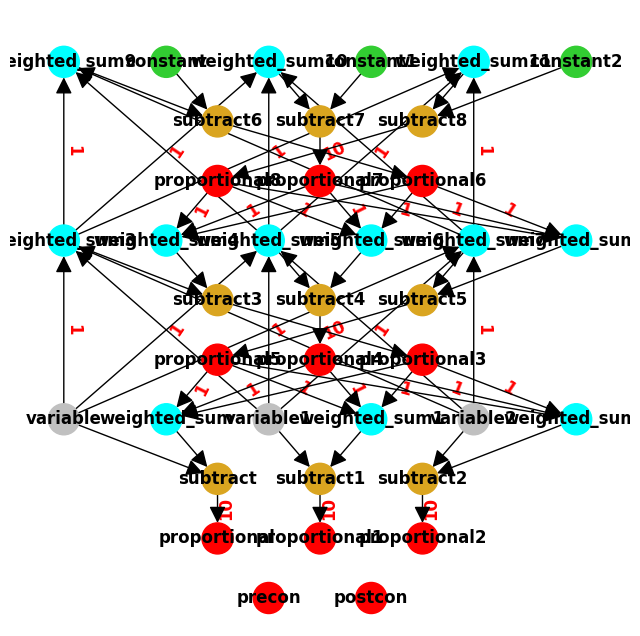

In [ ]:
# https://matplotlib.org/3.1.0/gallery/color/named_colors.html
loaded.draw(with_edge_labels=True, color_mapping={'w':'aqua','c':'limegreen','s':'goldenrod', 'p':'red', 'v':'silver'})

###### Examples


Build a hierarchy by adding nodes and functions manually.

Create an empty hierarchy.

In [ ]:
myhpct = PCTHierarchy()
namespace=myhpct.namespace
myhpct.summary(build=False)

**************************
pcthierarchy PCTHierarchy [] b0b59b17-dd58-11ed-a180-5c879cf9f59b
--------------------------
PRE: None
POST: None
**************************


Add a node. Then nodes at particular positions.

In [ ]:
myhpct.add_node(PCTNode(namespace=namespace))
myhpct.add_node(PCTNode(namespace=namespace), level=1)
myhpct.add_node(PCTNode(namespace=namespace), level=0)
myhpct.summary(build=False)

**************************
pcthierarchy PCTHierarchy [2, 1] b0b59b17-dd58-11ed-a180-5c879cf9f59b
--------------------------
PRE: None
Level 0 Cols 2
pctnode2 PCTNode
----------------------------
REF: constant2 Constant | 0 
PER: variable2 Variable | 0 
COM: subtract2 Subtract | 0 
OUT: proportional2 Proportional | gain 1 | 0 
----------------------------
pctnode PCTNode
----------------------------
REF: constant Constant | 0 
PER: variable Variable | 0 
COM: subtract Subtract | 0 
OUT: proportional Proportional | gain 1 | 0 
----------------------------
Level 1 Cols 1
pctnode1 PCTNode
----------------------------
REF: constant1 Constant | 0 
PER: variable1 Variable | 0 
COM: subtract1 Subtract | 0 
OUT: proportional1 Proportional | gain 1 | 0 
----------------------------
POST: None
**************************


Replace functions at particular positions in the hierarchy.

In [ ]:
myhpct.insert_function(level=0, col=0, collection="perception", function=Proportional(3, name="prop2", namespace=namespace))
myhpct.insert_function(level=1, col=0, collection="perception", function=WeightedSum(weights=[1,1], name="wsum", namespace=namespace))
myhpct.insert_function(level=0, col=1, collection="reference", function=Proportional(1, name="passthru", namespace=namespace))

Add pre and post processor functions.

In [ ]:
myhpct.add_preprocessor(Constant(1, name="cons1", namespace=namespace))
myhpct.add_preprocessor(Proportional(5, name="prop1", namespace=namespace))
myhpct.add_postprocessor(Proportional(5, name="postprop1", namespace=namespace))
myhpct.add_postprocessor(Proportional(5, name="postprop2", namespace=namespace))

Link the functions together.

In [ ]:
myhpct.set_links("prop1", "cons1")
myhpct.set_links("prop2", "prop1")
myhpct.add_links("wsum", "prop2", "variable")
myhpct.set_links("passthru", "proportional1")
myhpct.set_links("postprop1", "proportional")
myhpct.set_links("postprop2", "postprop1")

In [ ]:
myhpct.get_node(0,0).get_function('reference').set_value(1)
myhpct.get_node(1,0).get_function('reference').set_value(1)
myhpct.get_node(0,0).get_function('output').set_property('gain', 10)
myhpct.get_node(0,1).get_function('output').set_property('gain', 10)
myhpct.get_node(1,0).get_function('output').set_property('gain', 10)
myhpct.summary(build=True)

**************************
pcthierarchy PCTHierarchy [2, 1] b0b59b17-dd58-11ed-a180-5c879cf9f59b
--------------------------
PRE: cons1 Constant | 1 
prop1 Proportional | gain 5 | 0 | links  cons1 
Level 0 Cols 2
pctnode2 PCTNode
----------------------------
REF: constant2 Constant | 1 
PER: prop2 Proportional | gain 3 | 0 | links  prop1 
COM: subtract2 Subtract | 0 | links  constant2 prop2 
OUT: proportional2 Proportional | gain 10 | 0 | links  subtract2 
----------------------------
pctnode PCTNode
----------------------------
REF: passthru Proportional | gain 1 | 0 | links  proportional1 
PER: variable Variable | 0 
COM: subtract Subtract | 0 | links  passthru variable 
OUT: proportional Proportional | gain 10 | 0 | links  subtract 
----------------------------
Level 1 Cols 1
pctnode1 PCTNode
----------------------------
REF: constant1 Constant | 1 
PER: wsum WeightedSum | weights [1, 1] | 0 | links  prop2 variable 
COM: subtract1 Subtract | 0 | links  constant1 wsum 
OUT: proportion

In [ ]:
myhpctconfig = myhpct.get_config()
#print(myhpctconfig)
assert myhpctconfig == {'type': 'PCTHierarchy', 'name': 'pcthierarchy', 'pre': {'pre0': {'type': 'Constant', 'name': 'cons1', 'value': 1, 'links': {}}, 'pre1': {'type': 'Proportional', 'name': 'prop1', 'value': 0, 'links': {0: 'cons1'}, 'gain': 5}}, 'levels': {'level0': {'level': 0, 'nodes': {'col0': {'col': 0, 'node': {'type': 'PCTNode', 'name': 'pctnode2', 'refcoll': {'0': {'type': 'Constant', 'name': 'constant2', 'value': 1, 'links': {}}}, 'percoll': {'0': {'type': 'Proportional', 'name': 'prop2', 'value': 0, 'links': {0: 'prop1'}, 'gain': 3}}, 'comcoll': {'0': {'type': 'Subtract', 'name': 'subtract2', 'value': 0, 'links': {0: 'constant2', 1: 'prop2'}}}, 'outcoll': {'0': {'type': 'Proportional', 'name': 'proportional2', 'value': 0, 'links': {0: 'subtract2'}, 'gain': 10}}}}, 'col1': {'col': 1, 'node': {'type': 'PCTNode', 'name': 'pctnode', 'refcoll': {'0': {'type': 'Proportional', 'name': 'passthru', 'value': 0, 'links': {0: 'proportional1'}, 'gain': 1}}, 'percoll': {'0': {'type': 'Variable', 'name': 'variable', 'value': 0, 'links': {}}}, 'comcoll': {'0': {'type': 'Subtract', 'name': 'subtract', 'value': 0, 'links': {0: 'passthru', 1: 'variable'}}}, 'outcoll': {'0': {'type': 'Proportional', 'name': 'proportional', 'value': 0, 'links': {0: 'subtract'}, 'gain': 10}}}}}}, 'level1': {'level': 1, 'nodes': {'col0': {'col': 0, 'node': {'type': 'PCTNode', 'name': 'pctnode1', 'refcoll': {'0': {'type': 'Constant', 'name': 'constant1', 'value': 1, 'links': {}}}, 'percoll': {'0': {'type': 'WeightedSum', 'name': 'wsum', 'value': 0, 'links': {0: 'prop2', 1: 'variable'}, 'weights': [1.0, 1.0]}}, 'comcoll': {'0': {'type': 'Subtract', 'name': 'subtract1', 'value': 0, 'links': {0: 'constant1', 1: 'wsum'}}}, 'outcoll': {'0': {'type': 'Proportional', 'name': 'proportional1', 'value': 0, 'links': {0: 'subtract1'}, 'gain': 10}}}}}}}, 'post': {'post0': {'type': 'Proportional', 'name': 'postprop1', 'value': 0, 'links': {0: 'proportional'}, 'gain': 5}, 'post1': {'type': 'Proportional', 'name': 'postprop2', 'value': 0, 'links': {0: 'postprop1'}, 'gain': 5}}}

Define the order in which the node will be processed.

In [ ]:
myhpct.set_order(["pctnode2", "pctnode1", "pctnode"])

Run the hierarchy once.

In [ ]:
out = myhpct(verbose=True)
print(out)
assert out == -35000

1.000 5.000 
pctnode2 1.000 15.000 -14.000 -140.000 
pctnode1 1.000 [15, [15, 0], [1, 1]] 15.000 -14.000 -140.000 
pctnode -140.000 0.000 -140.000 -1400.000 
-7000.000 -35000.000 
-35000


In [ ]:
# config =  {'type': 'Individual', 'name': 'pcthierarchy', 'pre': {'pre0': {'type': 'CartPoleV1', 'name': 'CartPoleV1', 'value': [0.03498833197860944, 0.20994561633454428, 0.012668159509212712, -0.2705237130920193, 0.047656152654718356], 'links': {0: 'Action1'}, 'env_name': 'CartPole-v1', 'reward': 1.0, 'done': False, 'info': {}}, 'pre1': {'type': 'IndexedParameter', 'name': 'ICV', 'value': 0.20994561633454428, 'links': {0: 'CartPoleV1'}, 'index': 1}, 'pre2': {'type': 'IndexedParameter', 'name': 'ICP', 'value': 0.03498833197860944, 'links': {0: 'CartPoleV1'}, 'index': 0}, 'pre3': {'type': 'IndexedParameter', 'name': 'IPV', 'value': -0.2705237130920193, 'links': {0: 'CartPoleV1'}, 'index': 3}, 'pre4': {'type': 'IndexedParameter', 'name': 'IPA', 'value': 0.012668159509212712, 'links': {0: 'CartPoleV1'}, 'index': 2}}, 'levels': {'level0': {'level': 0, 'nodes': {'col0': {'col': 0, 'node': {'type': 'PCTNode', 'name': 'L0C0', 'refcoll': {'0': {'type': 'EAConstant', 'name': 'RL0C0', 'value': 0, 'links': {}}}, 'percoll': {'0': {'type': 'EAWeightedSum', 'name': 'PL0C0', 'value': -0.2705237130920193, 'links': {0: 'ICV', 1: 'ICP', 2: 'IPV', 3: 'IPA'}, 'weights': [0, 0, 1, 0]}}, 'comcoll': {'0': {'type': 'Subtract', 'name': 'CL0C0', 'value': 0.2705237130920193, 'links': {0: 'RL0C0', 1: 'PL0C0'}}}, 'outcoll': {'0': {'type': 'EAProportional', 'name': 'OL0C0', 'value': -0.05046166000036782, 'links': {0: 'CL0C0'}, 'gain': -0.1865332226280776}}}}}}}, 'post': {'post0': {'type': 'EAWeightedSum', 'name': 'Action1', 'value': -0.005282911840894066, 'links': {0: 'OL0C0'}, 'weights': [0.10469159835121472]}}}
# ind = PCTHierarchy.from_config(config)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()